In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

## General Idea for convolutions and padding

At every time the charts need to be surrounded by padding (g-padding, see paper figure 4). One could achive this by using "valid" convolutions and then "glue" new padding to the output after each convolution. The better strategy I think is to use "same" convolution and simply overwrite the results with the g-padding. This is also what I have implemented below.

In any way, we additionally will need to augment the input data to the CNN: It will probably not contain any padding and thus we will need to view() it as seperate charts, then pad each chart (can be done with zeros), then go back to view as a whole. And then we are able to apply g-padding here as well. 

# Create a sample image batch

Create a typical input batch that we would encounter. First we start with a "scalar"/Z2 feature, later we will need to generalize this to P6 features.

In [3]:
batchsize = 5
height_single = 8  # height of a single chart 
n_charts = 5
n_channels = 3
width = 2*height_single # width of the chart
height = n_charts*height_single

a_0 = np.arange(int(batchsize*n_channels*height*width/50),batchsize*n_channels*height*width+int(batchsize*n_channels*height*width/50))
t = torch.from_numpy(a_0)


t = t.view(batchsize, n_channels, -1, height_single, width)

pad = (1,1,1,1)
t = F.pad(t, pad, "constant", -50)

#reshape to simulate a typical situation
t = t.view(batchsize, n_channels, height+2*5, width+2)

Now we are at a typical starting position. Data like this can be the output of a previous conv-layer.

Develop a procedure to do the padding. First starting with the simple "scalar/Z2" case.

In [4]:
def g_padding(t):
    """
    Do G-Padding. Assume the inputdata already has the shape "with padding". t should be of shape 
    (batchsize, n_channels, n_charts*(height_chart+padding), (width_chart+padding))
    """
    bs = t.shape[0]
    n_ch = t.shape[1]
    h = int(t.shape[2]/5-2)  # true height of a single map without padding
    w = int(t.shape[3]-2)  # true width of a single map without padding

    # split the tensor into the individual charts (at least in view)
    t_v = t.view(bs, n_ch, -1, h+2, w+2)


    # set "cornerpoints" of icosahedron on the inside of the chart to zero
    t_v[:,:,:,-2,1::h] = 0

    # left edge
    for i in range(n_charts):
        # POSSIBLY PERMUTE
        # depending on what type we use we might need to cyclically permute over rotation index first.
        t_v[:,:,i,1:-1,0] = t_v[:,:,(i+1)%n_charts,1,1:h+1]
    # upper edge
    t_v[:,:,:,0,1] = 0 #  set single pixel to zero.
    t_v[:,:,:,0,0] = 0 #  set single pixel to zero.
    t_v[:,:,:,-1,0] = 0 #  set single pixel to zero.
    t_v[:,:,:,-1,-1] = 0 #  set single pixel to zero.
    for i in range(n_charts):
        # POSSIBLY PERMUTE
        # left upper edge
        t_v[:,:,i,0,2:h+2] = t_v[: ,:, (i-1)%n_charts, 1:-1, 1]
        # right upper edge
        t_v[:,:,i,0,h+1:-1] = t_v[: ,:, (i-1)%n_charts, -2, 1:h+1]

    # right edge
    for i in range(n_charts):  
        # POSSIBLY PERMUTE
        t_v[:,:,i,0:-2,-1] = t_v[:,:,(i-1)%n_charts, -2, h+1:-1]

    # lower edge
    for i in range(n_charts):
        # lower left edge
        t_v[:,:,i,-1,1:h+1] = t_v[: ,:, (i+1)%n_charts, 1, h+1:-1]
        # POSSIBLY PERMUTE
        # lower right edge
        t_v[:,:,i,-1,h+1:-1] = t_v[:, :, (i+1)%n_charts, 1:-1,-2]

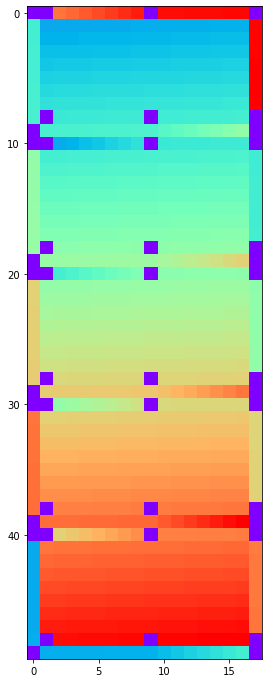

In [5]:
g_padding(t)
plt.figure(figsize=(5,12))
plt.imshow(t[0,0,...],cmap='rainbow')
# plt.imshow(t.view(batchsize, n_channels, height, width)[0,0,...])

In [48]:
m = torch.nn.MaxPool2d(2, stride=2)
ts = t.shape
x = t.reshape(ts[0], ts[1], 1, ts[-2], ts[-1])
x.shape

xs = x.shape
x = x.view(xs[0], xs[1], 5, -1, xs[-1])  # reshape to individual charts
x = x[..., 1:-1, 1:-1]  # get rid of padding of the individual charts
x = x.reshape(xs[0], xs[1], xs[-2]-2*5, xs[-1]-2)  # reshape back into original shape.
x = x.double()
x = m(x)

# pad the downsized charts.
xs = x.size()
x = x.view(xs[0], xs[1], 5, -1, xs[-1])
x = F.pad(x, (1, 1, 1, 1))  # pad the individual charts
x = x.view(xs[0], xs[1], -1, xs[-1]+2)  # merge the charts

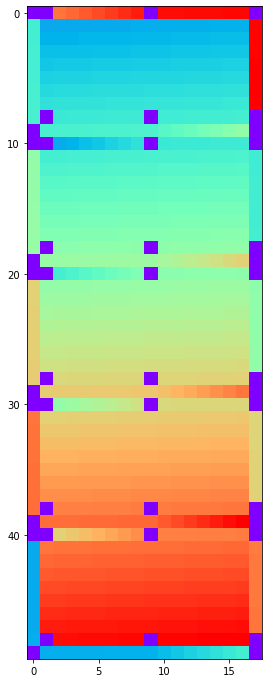

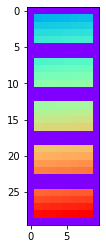

In [51]:
g_padding(t)
plt.figure(figsize=(5,12))
plt.imshow(t[0,0,...],cmap='rainbow')
plt.show()
plt.imshow(x[0,0,...],cmap='rainbow')
plt.show()
# plt.imshow(t.view(batchsize, n_channels, height, width)[0,0,...])

Since this is not at all readable, recreate the one from the paper by hand. (will be figure 5)

In [21]:
batchsize = 1
height_single = 4  # height of a single chart 
n_charts = 5
n_channels = 3
width = 2*height_single # width of the chart
height = n_charts*height_single

a_0 = np.arange(int(batchsize*n_channels*height*width/50),batchsize*n_channels*height*width+int(batchsize*n_channels*height*width/50))
t2 = torch.from_numpy(a_0)


t2 = t2.view(batchsize, n_channels, -1, height_single, width)

pad = (1,1,1,1)
t2 = F.pad(t2, pad, "constant", 0)

#reshape to simulate a typical situation
t2[...,1:-2,2:-1]  = 35

# set "cornerpoints" of icosahedron on the inside of the chart to zero
t2[:,:,:,-2,1::height_single] = 0

perm = np.random.permutation(30) + 2

for i in range(5):
    t2[...,i,1:-2,1] = perm[6*i]
    t2[...,i,1:-2,height_single+1] = perm[6*i+1]
    t2[...,i,-2,2:height_single+1] = perm[6*i+2]
    t2[...,i,-2,height_single+2:-1] = perm[6*i+3]
    
    t2[...,i,3,2] = perm[6*i+4]
    t2[...,i,2,3] = perm[6*i+4]
    t2[...,i,1,4] = perm[6*i+4]
    
    t2[...,i,3,2+height_single] = perm[6*i+5]
    t2[...,i,2,3+height_single] = perm[6*i+5]
    t2[...,i,1,4+height_single] = perm[6*i+5]

t2 = t2.view(batchsize, n_channels, height+2*5, width+2)

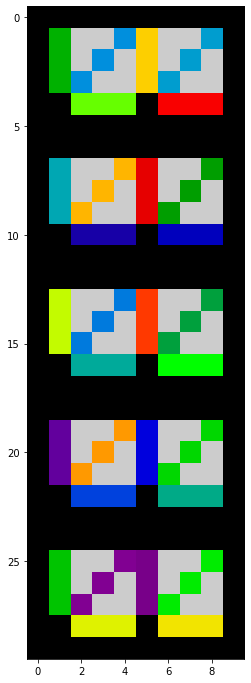

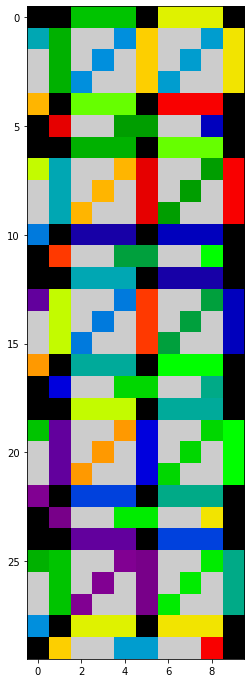

In [22]:
plt.figure(figsize=(5,12))
plt.imshow(t2[0,0,...],cmap='nipy_spectral')
plt.show()
plt.close()


g_padding(t2)
plt.figure(figsize=(5,12))
plt.imshow(t2[0,0,...],cmap='nipy_spectral')
plt.show()
plt.close()

# Cyclic permutation of tensor along one axis

In a realistic situation we don't only have scalar quantities, but the data has the shape  $(batchsize, n_{channels}, n_{inputstabilizer}, n_{charts}, height_{single}, width)$, where $n_{inputstabilizer}$ typically is 6 (for six possible rotations around hexagon).

If necessary we can reshape and "merge" channels and stabilizer to a single axis.


To permute we can use torch.roll(tensor, shift, dims) to shift by shift. Example [1,2,3,4,5] gets shifted to [5,1,2,3,4] when using shift = 1

# Realistic stabilizer:

We need to be really careful to apply the correct rotation. Changing on the "stabilizer axis" in +1 direction (eg. from 0 to 1) results in a view that is rotated by pi/6 in math. positive/counterclockwise direction. Or alternatively a coord.system that is rotated in positive direction. 
Looking at the filter expansion we see that the filter gets rotated clockwise from channel to channel (c6_z2 filter) - this is analogue to rotating the featuremap counterclockwise/math pos.

Current idea (based on sketches, thoughts and what is written above): when one would need to rotate a edge counterclockwise to glue it together with the next hex, we need to roll with shift=-1, otherwise with shift=+1.

## Create sample batch

In [30]:
batchsize = 5
height_single = 4  # height of a single chart 
n_charts = 5
n_channels = 3
st_size = 1
width = 2*height_single # width of the chart
height = n_charts*height_single

a_0 = np.arange(batchsize*n_channels*height*width*st_size)
t = torch.from_numpy(a_0)


t = t.view(batchsize, n_channels*st_size, -1, height_single, width)

pad = (1,1,1,1)
t = F.pad(t, pad, "constant", -50)

#reshape to simulate a typical situation
t = t.view(batchsize, n_channels*st_size, height+2*5, width+2)

In [31]:
t.shape

torch.Size([5, 3, 30, 10])

In [32]:
def g_padding_full(t,in_stab_size):
    """
    Do G-Padding. Assume the inputdata already has the shape "with padding". t should be of shape 
    (batchsize, n_channels*(in_stab_size), n_charts*(height_chart+padding), (width_chart+padding))
    """
    bs = t.shape[0]
    assert in_stab_size in [1,6]  # check that the input stabilizer size is valid
    h = int(t.shape[-2]/5-2)  # true height of a single map without padding
    w = int(t.shape[-1]-2)  # true width of a single map without padding
    n_charts = 5

    # split the tensor into the individual charts (at least in view)
    t_v = t.view(bs, -1, in_stab_size, 5, h+2, w+2)

    t_v[...,0,1] = 0 #  set single pixel to zero.
    t_v[...,0,0] = 0 #  set single pixel to zero.
    t_v[...,-1,0] = 0 #  set single pixel to zero.
    t_v[...,-1,-1] = 0 #  set single pixel to zero.

    # set "cornerpoints" of icosahedron on the inside of the chart to zero
    t_v[...,-2,1::h] = 0

    rolled_tensor = torch.roll(t_v[...,1,1:h+1], shifts=+1, dims=-3) # pulled out of loop to make more efficient
    for i in range(n_charts):
        # depending on what type we use we might need to cyclically permute over rotation index first.
        # shift by +1 bc rot of edge cw
        t_v[...,i,1:-1,0] = rolled_tensor[...,(i+1)%n_charts,:] 

    # upper edge
    rolled_tensor = torch.roll(t_v[..., 1:-1, 1] ,shifts=-1,dims=-3)
    for i in range(5):
        # left upper edge - shift by -1 by rot of edge ccw
        t_v[...,i,0,2:h+2] = rolled_tensor[...,(i-1)%n_charts,:]
        # right upper edge
        t_v[...,i,0,h+1:-1] = t_v[..., (i-1)%n_charts, -2, 1:h+1]

    # right edge
    rolled_tensor = torch.roll(t_v[..., -2, h+1:-1], shifts=+1, dims=-3)
    for i in range(n_charts):  
        # shift by +1 bc rot of padded edge cw
        t_v[...,i,0:-2,-1] = rolled_tensor[...,(i-1)%n_charts,:]

    # lower edge
    rolled_tensor = torch.roll(t_v[..., 1:-1,-2], shifts=-1, dims=-3)
    for i in range(n_charts):
        # lower left edge
        t_v[...,i,-1,1:h+1] = t_v[..., (i+1)%n_charts, 1, h+1:-1]
        # POSSIBLY PERMUTE
        # lower right edge
        t_v[...,i,-1,h+1:-1] = rolled_tensor[..., (i+1)%n_charts,:]    

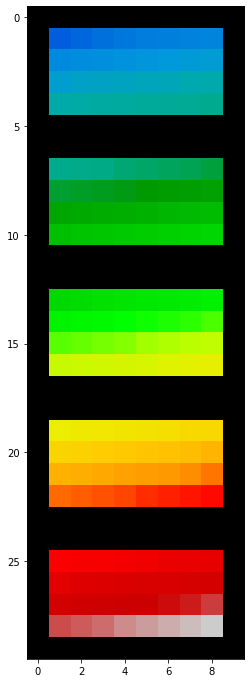

torch.Size([5, 3, 30, 10])


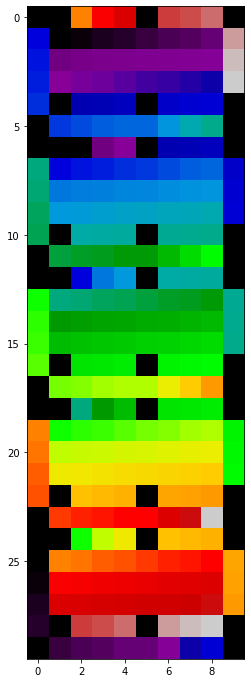

In [33]:
t_plot = t.view(batchsize, n_channels, st_size, height+2*5, width+2)
plt.figure(figsize=(5,12))
plt.imshow(t_plot[0,0,0,...],cmap='nipy_spectral')
plt.show()
plt.close()


g_padding_full(t,1)
plt.figure(figsize=(5,12))
plt.imshow(t_plot[0,0,0,...],cmap='nipy_spectral')
plt.show()
plt.close()